### 参考
Julia言語　https://julialang.org

Julia文法
https://docs.julialang.org

VSCodeで動かす
- https://code.visualstudio.com/docs/languages/julia

Jupyter Notebook で動かす
- https://qiita.com/hujuu/items/12a5d16354fcc629200e
- https://github.com/JuliaLang/IJulia.jl

JuliaにIJuliaをインストールすると VSCodeのJupyter拡張機能でもJuliaを実行できる
このファイルでは **Julia 1.9.2** を用いています
古いバージョンのJuliaでCSVパッケージのロードエラーが出る場合は[こちら](https://github.com/JuliaData/CSV.jl/issues/868) を参考に。

In [112]:
# パッケージの追加
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("StatsPlots")
Pkg.add("PyPlot")
Pkg.add("PlotlyJS")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
   Installed StatsFuns ─────────────── v1.3.0
   Installed Calculus ──────────────── v0.5.1
   Installed HypergeometricFunctions ─ v0.3.17
   Installed FFTW ──────────────────── v1.7.1
   Installed IntelOpenMP_jll ───────── v2023.1.0+0
   Installed PDMats ────────────────── v0.11.17
   Installed OffsetArrays ──────────── v1.12.10
   Installed NearestNeighbors ──────── v0.4.13
   Installed StaticArrays ──────────── v1.6.0
   Installed StaticArraysCore ──────── v1.4.0
   Installed Distances ─────────────── v0.10.8

In [225]:
using CSV
using DataFrames
using Dates
df = CSV.read("../merged_202204-202303.csv", DataFrame) #csvのDataFrameへの読み込み (UTF-8)
df = df[df.date.!="date",:] # csvをマージした際の不要なラベル行の削除
df.date = Date.(df.date, "yyyy/mm/dd HH:MM:SS")  # date行を文字列から時刻オブジェクトへ変換
df.week = Dates.lastdayofweek.(df.date) # dateをlastdayofweekに変換し、week列を追加
first(df,5) # 確認のため、最初の5行のみ出力

Row,date,URL,description,week
,Date,String,String,Date
1,2022-04-01,https://www-cr-mufg-jp.lgoo666.com/?ja=ulcvg.m88jb,三菱UFJニコス,2022-04-03
2,2022-04-01,https://www-cr-mufg-jp.lgoo666.com/select/,三菱UFJニコス,2022-04-03
3,2022-04-01,https://armzon.veribelcenter.com/,エポスカード,2022-04-03
4,2022-04-01,https://amaounz.jdfuhrtjt8.top/,Amazon,2022-04-03
5,2022-04-01,https://www2.epoesnacasn.icu,エポスカード,2022-04-03


In [226]:
top30_desc = first(sort!(combine(groupby(df, [:description]), nrow),order(:nrow, rev=true)),30).description # top30 descriptionのリストを作成
top30_df = df[in.(df.description, Ref(top30_desc)), :] #元のdfからtop30のdescriptionのデータのみを抽出しtop30_dfに保存
pivot_df = combine(groupby(top30_df, [:week,:description]), :URL => length ∘ unique => :cURL) #　weekごとにグルーピングし、Pivot化したデータフレームとして出力
first(pivot_df,5) # 確認のため、最初の5行のみ出力

Row,week,description,cURL
,Date,String,Int64
1,2022-04-03,三菱UFJニコス,59
2,2022-04-03,エポスカード,8
3,2022-04-03,Amazon,6
4,2022-04-03,Viewcard,1
5,2022-04-03,アプラス,2


In [227]:

others_df = df[.!in.(df.description, Ref(top30_desc)), :] # top30を元のDataFrameから削除した残りをOTHRESとして抽出
others_df[!,"description"] .= "OTHERS" # description列にOTHERSと全て代入
others_df = combine(groupby(others_df,[:week,:description]) ,:URL => length ∘ unique => :cURL) # week、descriptionごとにグルーピングし、Pivot化したデータフレームとして出力
first(others_df,5) # 確認のため、最初の5行のみ出力

Row,week,description,cURL
,Date,String,Int64
1,2022-04-03,OTHERS,14
2,2022-04-10,OTHERS,106
3,2022-04-17,OTHERS,88
4,2022-04-24,OTHERS,63
5,2022-05-01,OTHERS,55


In [228]:
pivot_df = vcat(pivot_df, others_df) # top30とothersのDataFrameの合成

Row,week,description,cURL
,Date,String,Int64
1,2022-04-03,三菱UFJニコス,59
2,2022-04-03,エポスカード,8
3,2022-04-03,Amazon,6
4,2022-04-03,Viewcard,1
5,2022-04-03,アプラス,2
6,2022-04-03,JCB,6
7,2022-04-03,au,80
8,2022-04-03,イオンカード,28
9,2022-04-03,Apple ID,16


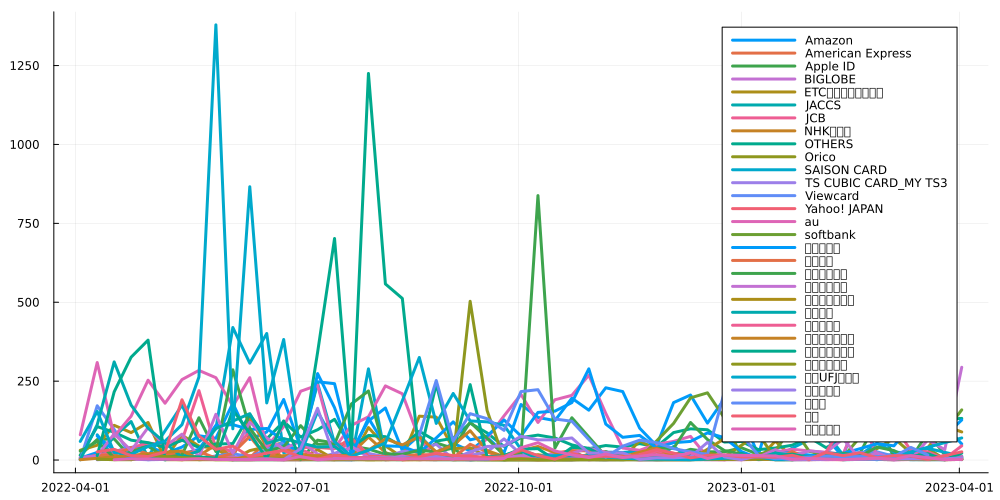

GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS: 
GKS:

In [229]:
# Juliaの標準Plotsでの描画

using Plots,StatsPlots
plots_df = DataFrame(pivot_df)
@df plots_df StatsPlots.plot(:week, :cURL, group=:description, linewidth=3, size=(1000,500))

In [230]:
# PlotlyJSでの描画

using PlotlyJS

plotly_df = DataFrame(pivot_df)
PlotlyJS.plot(plotly_df, mode="lines", x=:week, y=:cURL, group=:description)

data: [
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis",
  "scatter with fields legendgroup, mode, name, type, x, xaxis, y, and yaxis"
]

layout: "layout with fields legend, margin, template, xaxis, and yaxis"

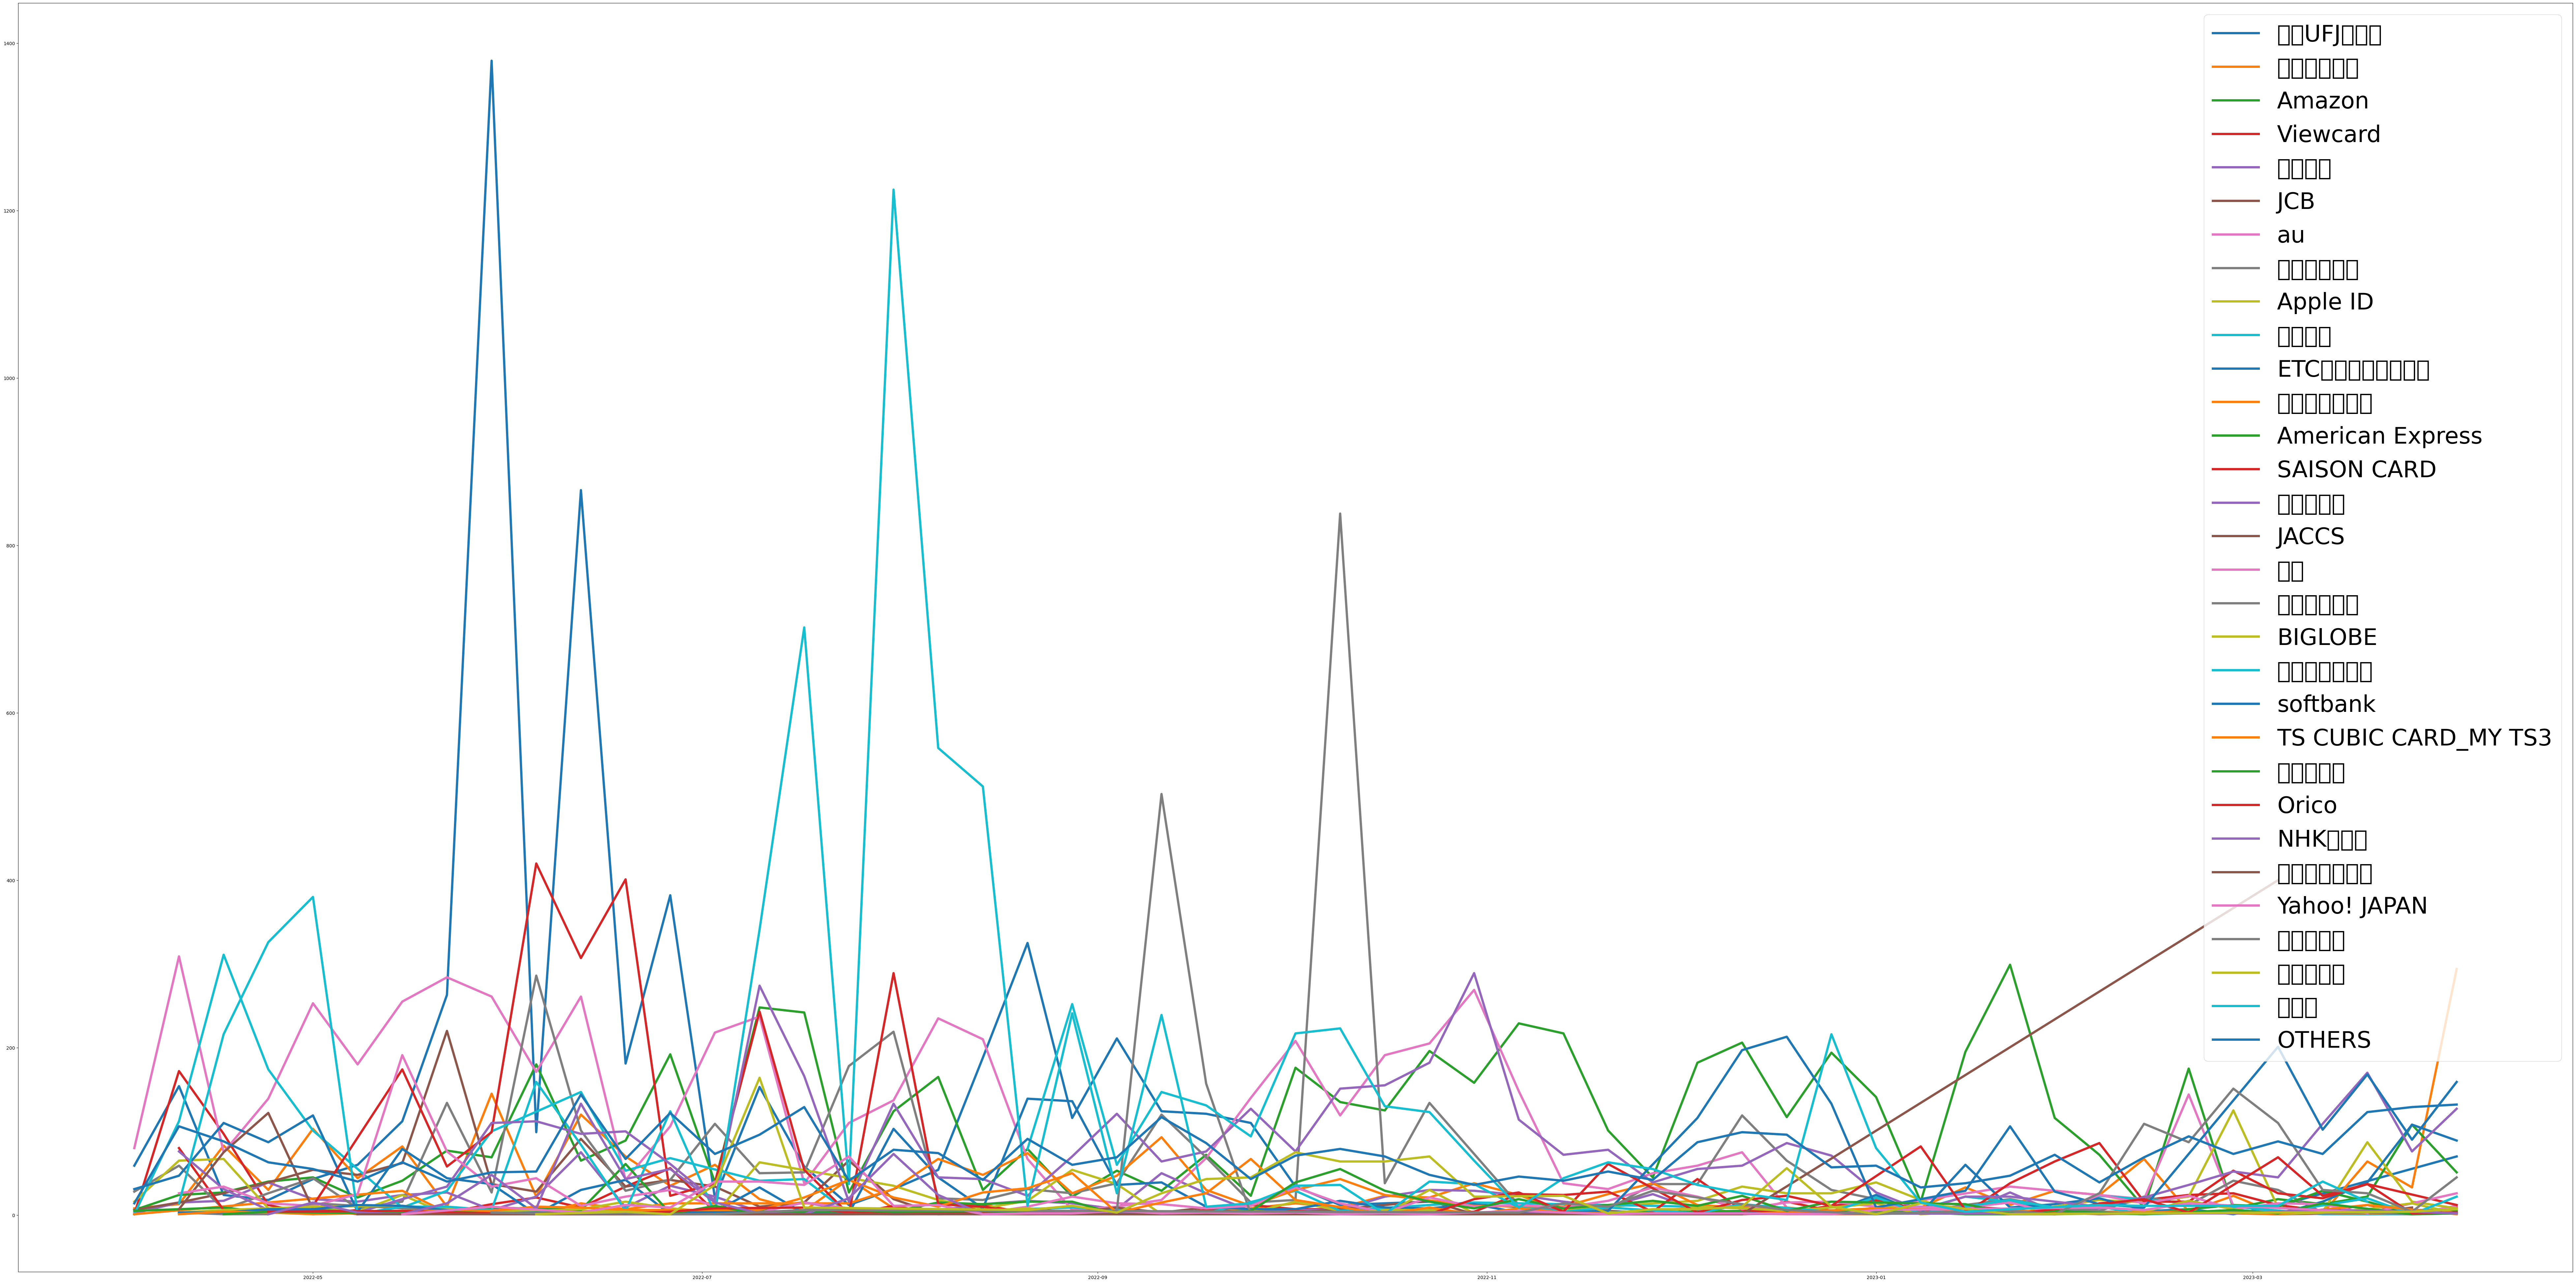

PyObject <matplotlib.legend.Legend object at 0x241cda110>

In [231]:
# PyPlotでの描画

using PyPlot
pyplot_df = DataFrame(pivot_df) 
desc_vec = combine(groupby(pyplot_df, [:description]), :cURL => sum).description
PyPlot.figure(figsize=(100,50))
for desc in desc_vec
    PyPlot.plot(pyplot_df[pyplot_df.description.==desc,:].week, pyplot_df[pyplot_df.description.==desc,:].cURL, label=desc,linewidth=5)
end
PyPlot.legend(desc_vec,fontsize=50)